In [30]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import numpy as np
import os

# json_file = 'Data\D1_flexion_golden_repetition.json'
# json_file = 'Data\python_lbue4-loop_720p_flip.json'
# json_file = 'Data\python_md54-side-loop_720p_flip.json'
# json_file = 'Data\python_md55-loop_720p_flip.json'
# json_file = 'Data\squat_golden_repetition.json'
json_file = '/content/jitter.json'

# Load the data
with open(json_file, 'r') as file:
    data = json.load(file)


In [31]:
def get_body_parts(data):
    """
    This function returns 'body_parts' dictionary, that links the name of the body part, with its index.
    """
    try:
        body_parts = {node['name']: node['index'] for node in data['used_nodes']}
    except KeyError:
        # Some exercises (f.e. 'D1_flexion) do not contain the 'used_nodes' key, so let's assume the following:
        body_parts = {
            'NOSE': 0,
            'LEFT_EYE': 1,
            'RIGHT_EYE': 2,
            'LEFT_EAR': 3,
            'RIGHT_EAR': 4,
            'LEFT_SHOULDER': 5,
            'RIGHT_SHOULDER': 6,
            'LEFT_ELBOW': 7,
            'RIGHT_ELBOW': 8,
            'LEFT_WRIST': 9,
            'RIGHT_WRIST': 10,
            'LEFT_HIP': 11,
            'RIGHT_HIP': 12,
            'LEFT_KNEE': 13,
            'RIGHT_KNEE': 14,
            'LEFT_FOOT': 15,
            'RIGHT_FOOT': 16
        }
    return body_parts
def get_list_of_positions(data):
    """
    This function preprocesses the 'golden_rep_poses' key into a list of frames.
    Each frame is a list of tuples (x, y) representing the position of each node.
    """
    list_of_positions = []
    try:
        for timestamp in data['golden_rep_poses']:
            positions = timestamp['pose']
            list_of_tuples_for_each_timestamp = [
                [positions[i], positions[i+1]] for i in range(0, 34, 2)
            ]
            list_of_positions.append(list_of_tuples_for_each_timestamp)
    except:
        pose_data = data["golden_video_metadata"]["pose"]

        for pose in pose_data:
            pose = pose[1:] # first element is a time
            list_of_tuples_for_each_pose = [
                [pose[i], pose[i+1]] for i in range(0, 34, 2)
            ]
            list_of_positions.append(list_of_tuples_for_each_pose)

    return list_of_positions

def transform_list_of_positions(list_of_positions):
    """the function can be extended, for now I need only to reflect the node by liney=0.5, as the image is
    upside-down

    When we will need to add a scale it's a good place to do so.

    """
    for frame in list_of_positions:
        for node in frame:
            node[1] = -node[1]+1
            # print(node)

    return list_of_positions

def smooth_positions(list_of_positions, window_size=5):
    """Applies a moving average filter to smooth the positions of each node over time."""
    smoothed_positions = []
    for i in range(len(list_of_positions)):
        if i < window_size:
            smoothed_positions.append(list_of_positions[i])
        else:
            smoothed_frame = []
            for j in range(len(list_of_positions[i])):
                smoothed_x = np.mean([list_of_positions[k][j][0] for k in range(i-window_size, i+1)])
                smoothed_y = np.mean([list_of_positions[k][j][1] for k in range(i-window_size, i+1)])
                smoothed_frame.append([smoothed_x, smoothed_y])
            smoothed_positions.append(smoothed_frame)
    return smoothed_positions

def center_skeleton(list_of_positions):
    """Centers the skeleton in the frame by shifting all coordinates."""
    for frame in list_of_positions:
        # Calculate the center of the skeleton
        x_coords = [node[0] for node in frame]
        y_coords = [node[1] for node in frame]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)

        # Shift all nodes to center the skeleton
        for node in frame:
            node[0] -= center_x - 0.5  # Centering on the x-axis (0.5 is the center)
            node[1] -= center_y - 0.5  # Centering on the y-axis (0.5 is the center)
    return list_of_positions

def add_fake_point_between_A_and_B(A, B, list_of_positions, body_parts, name):
    """
    Adds a fake point between points A and B and appends it to each frame in list_of_positions.
    """
    for frame in list_of_positions:
        fake_point_x = (frame[body_parts[A]][0] + frame[body_parts[B]][0]) / 2
        fake_point_y = (frame[body_parts[A]][1] + frame[body_parts[B]][1]) / 2
        frame.append((fake_point_x, fake_point_y))
    body_parts[name] = len(body_parts)

def get_trace(node, list_of_positions, body_parts):
    trace = []
    node_index = body_parts[node]
    for frame in list_of_positions:
        trace.append(frame[node_index])

    return trace

def get_velocity(trace):
    x_vel = []
    y_vel = []
    for frame in trace:
        x_vel.append(frame[0])
        y_vel.append(frame[1])

    return np.gradient(np.array(x_vel)), np.gradient(np.array(y_vel))

HUMAN_BLUEPRINT = [
    ('LEFT_SHOULDER', 'LEFT_ELBOW'), ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'), ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('RIGHT_SHOULDER', 'LEFT_SHOULDER'), ('RIGHT_HIP', 'LEFT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'), ('LEFT_KNEE', 'LEFT_FOOT'),
    ('RIGHT_HIP', 'RIGHT_KNEE'), ('RIGHT_KNEE', 'RIGHT_FOOT')
]

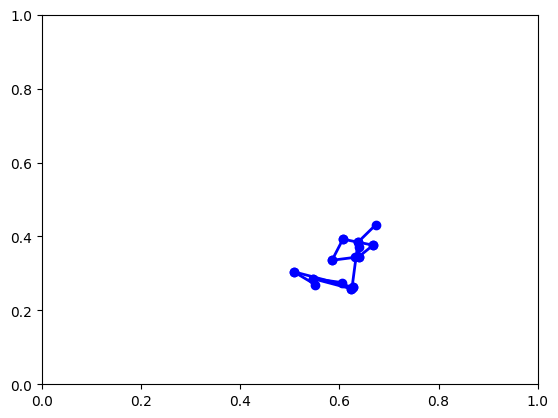

In [32]:
body_parts = get_body_parts(data)
list_of_positions = get_list_of_positions(data)
list_of_positions = transform_list_of_positions(list_of_positions)

# Smooth the positions
list_of_positions = smooth_positions(list_of_positions, window_size=5)

# Add fake point between hips to visualise the spine
add_fake_point_between_A_and_B('RIGHT_HIP', 'LEFT_HIP', list_of_positions, body_parts, 'MID_HIP')
add_fake_point_between_A_and_B('RIGHT_SHOULDER', 'LEFT_SHOULDER', list_of_positions, body_parts, 'MID_SHOULDER')

# Add the connection from the MID_HIP to the NOSE
HUMAN_BLUEPRINT.append(('MID_HIP', 'MID_SHOULDER'))
HUMAN_BLUEPRINT.append(('MID_SHOULDER', 'NOSE'))

# Convert HUMAN_BLUEPRINT to indexes
connections = [(body_parts[start], body_parts[end]) for start, end in HUMAN_BLUEPRINT]

trace = get_trace('MID_HIP', list_of_positions, body_parts)
x_vel, y_vel = get_velocity(trace)
velocity = np.sqrt(x_vel**2 + y_vel**2)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

lines = [ax.plot([], [], 'bo-', lw=2)[0] for _ in connections]
trace_line, = ax.plot([], [], 'r-', lw=1)
velocity_text = ax.text(0.3, 0.7, '', transform=ax.transAxes, color='black', fontsize=12, verticalalignment='top')

def animate(i):
    """Update the animation with each frame."""
    frame = list_of_positions[i]
    for line, (start, end) in zip(lines, connections):
        x = [frame[start][0], frame[end][0]]
        y = [frame[start][1], frame[end][1]]
        line.set_data(x, y)

    return lines + [trace_line]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(list_of_positions), interval=100, blit=True)
os.makedirs('Animations', exist_ok=True)
gif_path = os.path.join('Animations', os.path.basename(json_file).replace('.json', '_animation.gif'))
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.show()